# Project P4
## Usage of Balance Theory and Regression for Trade Suggestion in a Crypto-Currency Trading Platform

In this project, the aim is to study two different approaches for trade suggestion by a crypto-currency trading platform. The approaches are used to **predict the outcome of a trade between two traders based on their existing trade history data**.

The data is retieved from **Stanford Network Analysis Project (SNAP)** and includes the **ratings between the two sides of a trade**:

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np

import networkx as nx

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 2. Reading the Data
Now it's time to import the retrieved datasets. The datasets are in **compressed CSV format** (*.csv.gz*). 

Various columns in the data are separated using **comma**s and each row contains a single record.

The CSV files are read into DataFrames with the column names being consistent with the names provided by the authors in the **SNAP** database.

**All data are read from the corresponsing files in the Data folder.**

### 2.1. Bitcoin Alpha Dataset

In [2]:
Bitcoinalpha_df = pd.read_csv('./Data/soc-sign-bitcoinalpha.csv.gz', names = ['Source', 'Target', 'Rating', 'Time'])

Let's have a brief look into the loaded dataset.

In [3]:
Bitcoinalpha_df

,Source,Target,Rating,Time
0,7188,1,10,1407470400
1,430,1,10,1376539200
2,3134,1,10,1369713600
3,3026,1,10,1350014400
4,3010,1,10,1347854400
...,...,...,...,...
24181,7604,7601,10,1364270400
24182,7601,7604,10,1364270400
24183,7604,7602,10,1364270400
24184,7602,7604,10,1364270400


Let's check the data types in different columns and the values in the **Rating** column:

In [4]:
Bitcoinalpha_df.dtypes

Source    int64
Target    int64
Rating    int64
Time      int64
dtype: object

As seen there is no challange regarding the data types in the **Bitcoinalpha_df** DataFrame and all the columns contain the expected data types (let's say *int64* for numeric values)

In [5]:
Bitcoinalpha_df.Rating.unique()

array([ 10,   9,   7,   6,   5,   4,   3,   2,   1,  -1,   8,  -5, -10,
        -2,  -8,  -3,  -4,  -6,  -9,  -7], dtype=int64)

The **Rating** column contains the expected values of **10 to -10**.

### 2.2. Bitcoin OTC Dataset

In [6]:
Bitcoinotc_df = pd.read_csv('./Data/soc-sign-bitcoinotc.csv.gz', names = ['Source', 'Target', 'Rating', 'Time'])

Let's have a brief look into the loaded dataset.

In [7]:
Bitcoinotc_df

,Source,Target,Rating,Time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
...,...,...,...,...
35587,4499,1810,1,1.453612e+09
35588,2731,3901,5,1.453679e+09
35589,2731,4897,5,1.453679e+09
35590,13,1128,1,1.453680e+09


Let's check the data types in differenct columns and the values in the **Rating** column:

In [8]:
Bitcoinotc_df.dtypes

Source      int64
Target      int64
Rating      int64
Time      float64
dtype: object

The **Time** column in the **Bitcoinotc_df** DataFrame is formatted as **float64**, while the rest of the columns are formatted as **int64** as expected. As the values in the **Time** column are not going to be used in further steps, we can leave the DataFrame as is.

In [9]:
Bitcoinotc_df.Rating.unique()

array([  4,   2,   1,   7,   8,   5,   9,  10,   3,   6,  -1, -10,  -3,
        -6,  -5,  -4,  -2,  -8,  -9,  -7], dtype=int64)

The **Rating** column contains values of **10 to -10** as expected.

## 3. Trading Triads

Triads are one of the simplest sub-graphs that can be used as a representative of interactions in between the traders. Using them gives a higher level of information compared to edges, while not complicating the relative interactions.

Below, the functions that are being used for calculating the number of triad types in the following sub-sections of this section are presented:

In [10]:
def edge_sign_func(w):
    """
    returns the sign according to the given weight
    """
    if w > 0:
        sign = '+'
    else:
        sign = '-'
    
    return sign

def append_signs(sign_list):
    """
    generates triad type list using the outer product for the given sign lists
    """
    # outer product of 1st and 2nd lists
    tmp_list = (list(''.join(e) for e in itertools.product(sign_list[0], sign_list[1])))
    # outer product of the last product and 3rd list
    mixed_signs = (list(''.join(e) for e in itertools.product(tmp_list, sign_list[2])))
    # order the triad type so that +s come first
    mixed_signs = [''.join(sorted(item)) for item in mixed_signs]
    
    return mixed_signs

def triad_type_counter(df_triads, graph):
    """
    counts the triad types for the given graph and DataFrame of triads and then stores the number in that DataFrame
    """
    for row_id in df_triads.index.tolist():  # go through all rows of the triad DataFrame
        # initialize sign and weight lists
        sign_list = [[], [], []]
        weight_list = [[], [], []]

        sign_id = 0  # index for the item in the sign_list

        # go through edges: [01, 10], [02, 20], [12, 21]
        for i in [0, 1]:
            for j in [1, 2]:
                if i == j:
                    continue
                else:
                    # edge (i, j) exists?
                    if graph.has_edge(df_triads.iat[row_id, i], df_triads.iat[row_id, j]):
                        # extract the weights and append the signs to the sign lists
                        w = graph.get_edge_data(df_triads.iat[row_id, i], df_triads.iat[row_id, j])['Rating']
                        sign_list[sign_id].append(edge_sign_func(w))
                        weight_list[sign_id].append(w)

                    # edge (j, i) exists?
                    if graph.has_edge(df_triads.iat[row_id, j], df_triads.iat[row_id, i]):
                        # extract the weights and append the signs to the sign lists
                        w = graph.get_edge_data(df_triads.iat[row_id, j], df_triads.iat[row_id, i])['Rating']
                        sign_list[sign_id].append(edge_sign_func(w))
                        weight_list[sign_id].append(w)

                    sign_id += 1  # increment the item index in the sign_list

        # append the triad types into the corresponding lists
        mixed_signs = append_signs(sign_list)

        # increment up the number of each triad type in the corresponding DataFrame
        for col_name in mixed_signs:
            df_triads.at[row_id, col_name] += 1
            
        df_triads.at[row_id, '01'] = str(weight_list[0])
        df_triads.at[row_id, '02'] = str(weight_list[1])
        df_triads.at[row_id, '12'] = str(weight_list[2])
    
    return df_triads

### 3.1. Bitcoin Alpha Dataset
#### 3.1.1. Creating a directed graph from the dataset
Now a directed graph is created from the resulted DataFrame. The ratings are assigned to the generated edges as **edge attributes**. 

In [11]:
G_Bitcoinalpha_df = nx.from_pandas_edgelist(Bitcoinalpha_df, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

#### 3.1.2. Counting the triads in the dataset graph
With the directed graph all generated, it's time to extract all the triads in the generated graph. The *triadic_census* command counts all the 16 triad types in the given graph.

In [12]:
Bitcoinalpha_triads = nx.algorithms.triads.triadic_census(G_Bitcoinalpha_df)

Let's take a look at the count of the different types of triads in the graph of **Bitcoinalpha** data.

In [13]:
Bitcoinalpha_triads

{'003': 8963414292,
 '012': 14879710,
 '102': 36885677,
 '021D': 43677,
 '021U': 17083,
 '021C': 27095,
 '111D': 93989,
 '111U': 190593,
 '030T': 974,
 '030C': 64,
 '201': 413062,
 '120D': 1142,
 '120U': 1780,
 '120C': 1163,
 '210': 7136,
 '300': 9894}

After that the triads are found in the dataset, a list of desirable triad types is generated (**triad_list**). The list is then used to count the number of triads having the favorable type. 

In [14]:
triad_list = ['030T', '030C', '120D', '120U', '120C', '210', '300']

In [15]:
Bitcoinalpha_no_triads = 0
for triad_type in triad_list:
    Bitcoinalpha_no_triads += Bitcoinalpha_triads[triad_type]

Bitcoinalpha_no_triads

22153

It shall be noted that triad types other than **030T** and **030C** are actually representative of more than a single triad. Triad types **120D**, **120U**, and **120C** are representative of **two 3-edge triads** as there are two edges between a pair of nodes in those triad types. For the **210 type**, two edges exist between two pairs of nodes which means four 3-edge triads. Finally, for **300 type**, two edges exist between all node pairs which represents eight 3-edge triads.

**So, to calculate the total number of triads, we multiply the number of each triad type by the number of representative 3-edge triads and then sum the up together.**

In [16]:
triad_list_dic = {'030T': 1, '030C': 1, '120D': 2, '120U': 2, '120C': 2, '210': 4, '300': 8}

In [17]:
Bitcoinalpha_total_triads = 0
for key in triad_list_dic:
    Bitcoinalpha_total_triads += Bitcoinalpha_triads[key] * triad_list_dic[key]

Bitcoinalpha_total_triads

116904

So, **there are 116904 triads in total in the Bitcoin Alpha dataset**.

#### 3.1.3. Extracting triad nodes
Now that the number of each triad type is counted, we need the data for the nodes included in each of those triads. To do so, we use **NetworkX**'s **enumerate_all_cliques** capability. This function returns an *iterator over cliques, each of which is a list of nodes*. The iteration *is ordered by cardinality of the cliques*: first all cliques of size one, then all cliques of size two, etc.

The function just works on undirected graphs. Consequently, an undirected graph of the original directed graph is generated and then we iterate through all the cliques in that graph. As the iteration is order by cardinality of the cliques, **we can stop after all the 3rd-degree cliques are covered (triads)**.

**An empty DataFrame is filled up with all the nodes of the 3-rd degree cliques (triad)**. The number of rows in that DataFrame would be equal to the number of triads associated with **030T, 030C, 120D, 120U, 120C, 210, 300 types** as **their number follows the same concept as undirected graphs** *(back and forth edges between node pairs are considered as a unique item when being counted by triad type)*. Filling up an empty DataFrame with a pre-defined number of rows is much faster than creating a DataFrame and then appending rows into it.

In [18]:
# creating an undirected graph to be used
UG_Bitcoinalpha_df = G_Bitcoinalpha_df.to_undirected()

# iterator over the cliques in an undirected graph
all_cliques_Bitcoinalpha = nx.enumerate_all_cliques(UG_Bitcoinalpha_df)
# creating an empry DataFrame to be filled up with node data of triads
df_triads_Bitcoinalpha = pd.DataFrame(0, index=np.arange(Bitcoinalpha_no_triads), columns=['Node 1', 'Node 2', 'Node 3'])

idx = 0  # row counter
for x in all_cliques_Bitcoinalpha:  # iterate through all cliques
    if len(x) == 3:  # if it is a triad
        for i in np.arange(3):  # go through all its nodes
            df_triads_Bitcoinalpha.iat[idx, i] = int(x[i])  # and write those nodes to its relative location in DataFrame
        idx += 1  # increment up the row number
    elif len(x) > 3:  # all triads are covered?
        break  # finish it up!

Let's take a look into the triad node list DataFrame.

In [19]:
df_triads_Bitcoinalpha

,Node 1,Node 2,Node 3
0,1,430,247
1,1,430,817
2,1,3134,95
3,1,3134,617
4,1,3134,22
...,...,...,...
22148,7413,1950,1629
22149,7413,1629,1949
22150,465,559,560
22151,465,559,652


#### 3.1.4. Appending the corresponding columns for the number of triad types
Four columns of **+++**, **++-**, **+--**, and **---** are appended to the triads DataFrame so to keep the number of each triad type in them.

Also three additional columns of **01**, **02**, and **12** relating to the weights of the edges between the **Node 1 and Node 2**, **Node 1 and Node 3**, **and Node 3 and Node 2**, are appended to the DataFrame. These three columns are intended to keep the weights of the edges in a given triad.

In [20]:
df_triads_Bitcoinalpha["+++"] , df_triads_Bitcoinalpha["++-"], df_triads_Bitcoinalpha["+--"], df_triads_Bitcoinalpha["---"], df_triads_Bitcoinalpha['01'], df_triads_Bitcoinalpha['02'], df_triads_Bitcoinalpha['12'] = [0, 0, 0, 0, 'e', 'e', 'e']

In [21]:
df_triads_Bitcoinalpha

,Node 1,Node 2,Node 3,+++,++-,+--,---,01,02,12
0,1,430,247,0,0,0,0,e,e,e
1,1,430,817,0,0,0,0,e,e,e
2,1,3134,95,0,0,0,0,e,e,e
3,1,3134,617,0,0,0,0,e,e,e
4,1,3134,22,0,0,0,0,e,e,e
...,...,...,...,...,...,...,...,...,...,...
22148,7413,1950,1629,0,0,0,0,e,e,e
22149,7413,1629,1949,0,0,0,0,e,e,e
22150,465,559,560,0,0,0,0,e,e,e
22151,465,559,652,0,0,0,0,e,e,e


#### 3.1.5. Counting the number of triad types
As mentioned earlier, each of the rows correspond to a triad in an undirected graph. To properly calculated the number of triad types in a directed graph, it's required to control the edges that exist in between the node pairs in a triad. It works as follows:

*Let's number the Nodes 1, 2, and 3 as 0, 1, and 2 respectively.*

**The main procedures are performed by the triad_type_counter function that is already defined.**

1) The edges are studied in the following order: **[01, 10]**, **[02, 20]**, **[12, 21]**

2) For each edge pair of **[01, 10]**, or **[02, 20]** or **[12, 21]** it is verified that the edge exists in the **directed graph** (either **original** or **shuffled**).

3.1) If the edge exists, its sign is appended to a list. For example: *If both 01 and 10 exist, we may have: ['+', '+']. But if just one of them exists, we may have: ['+'].*

3.2) If the edge exists, its weight is also appended to a list. For example: *If both 01 and 10 exist, we may have: [7, 3]. But if just one of them exists, we may have: [7].*


4) We go through all the edge pairs and create the sign lists. We may have lists like this: *["+", "+"], ["-", "+"], ["+"]*

5) Having all the sign lists, it's now time to generate the respective triad types out of them. The defined **append_signs** function performs this task. It **generates the triad types using the outer product** and as a result *for the above lists we may have: ["+-+", "+-+", "+++", "+++"].*

6) As the order of + and - signs may differ from triad to triad, **we order them such that the +s always come first**.

7) Then we iterate through the triad type list generated in **step 5**. The number of the triad type in the respective DataFrame is incremented up.

8) The list of the weights recorded in step 3.2 is also inserted in the corresponding DataFrame columns at this stage.

9) Steps 1 through 8 are performed for each row of the triad node list DataFrame.

In [22]:
df_triads_Bitcoinalpha = triad_type_counter(df_triads_Bitcoinalpha, G_Bitcoinalpha_df)

Now it's time to take a look into the extracted number of the triad types:

In [23]:
df_triads_Bitcoinalpha.sum()[["+++", "++-", "+--", "---"]]

+++    98349
++-    13634
+--     4590
---      331
dtype: object

### 3.2. Bitcoin OTC Dataset
#### 3.2.1. Creating a directed graph from the dataset
Now a directed graph is created from the corresponding DataFrame. The ratings are assigned to the generated edges as **edge attributes**. 

In [24]:
G_Bitcoinotc_df = nx.from_pandas_edgelist(Bitcoinotc_df, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

#### 3.2.2. Counting the triads in the dataset graph
With the directed graph all generated, it's time to extract all the triads in the generated graph. The *triadic_census* command counts all the 16 triad types in the given graph.

In [25]:
Bitcoinotc_triads = nx.algorithms.triads.triadic_census(G_Bitcoinotc_df)

Let's take a look at the count of the different types of triads in the graph of **Bitcoinotc** data.

In [26]:
Bitcoinotc_triads

{'003': 33758222238,
 '012': 42302051,
 '102': 80757538,
 '021D': 153801,
 '021U': 36648,
 '021C': 65143,
 '111D': 169731,
 '111U': 440712,
 '030T': 3706,
 '030C': 79,
 '201': 729665,
 '120D': 2048,
 '120U': 2910,
 '120C': 1621,
 '210': 9377,
 '300': 13752}

After that the triads are found in the dataset, the number of triads inluded in **triad_list** is counted. 

In [27]:
Bitcoinotc_no_triads = 0
for triad_type in triad_list:
    Bitcoinotc_no_triads += Bitcoinotc_triads[triad_type]

Bitcoinotc_no_triads

33493

It shall be noted that triad types other than **030T** and **030C** are actually representative of more than a single triad. Triad types **120D**, **120U**, and **120C** are representative of **two 3-edge triads** as there are two edges between a pair of nodes in those triad types. For the **210 type**, two edges exist between two pairs of nodes which means four 3-edge triads. Finally, for **300 type**, two edges exist between all node pairs which represents eight 3-edge triads.

**So, to calculate the total number of triads, we multiply the number of each triad type by the number of representative 3-edge triads and then sum the up together.**

In [28]:
Bitcoinotc_total_triads = 0
for key in triad_list_dic:
    Bitcoinotc_total_triads += Bitcoinotc_triads[key] * triad_list_dic[key]
    
Bitcoinotc_total_triads

164467

So, **there are 164467 triads in total in the Bitcoin OTC dataset**.

#### 3.2.3. Extracting Triad Nodes
Just like what was performed for the **Bitcoin Alpha** dataset, an undirected graph of the original directed graph is generated and then we iterate through all the cliques in that graph. As the iteration is order by cardinality of the cliques, **we can stop after all the 3rd-degree cliques are covered (triads)**.

**An empty DataFrame is then filled up with all the nodes of the 3-rd degree cliques (triad)**.

In [29]:
# creating an undirected graph to be used
UG_Bitcoinotc_df = G_Bitcoinotc_df.to_undirected()

# iterator over the cliques in an undirected graph
all_cliques_Bitcoinotc = nx.enumerate_all_cliques(UG_Bitcoinotc_df)
# creating an empry DataFrame to be filled up with node data of triads
df_triads_Bitcoinotc = pd.DataFrame(0, index=np.arange(Bitcoinotc_no_triads), columns=['Node 1', 'Node 2', 'Node 3'])

idx = 0  # row counter
for x in all_cliques_Bitcoinotc:  # iterate through all cliques
    if len(x) == 3:  # if it is a triad
        for i in np.arange(3):  # go through all its nodes
            df_triads_Bitcoinotc.iat[idx, i] = int(x[i])  # and write those nodes to its relative location in DataFrame
        idx += 1  # increment up the row number
    elif len(x) > 3:  # all triads are covered?
        break  # finish it up!

Let's take a look into the triad node list DataFrame.

In [30]:
df_triads_Bitcoinotc

,Node 1,Node 2,Node 3
0,6,2,1
1,6,2,4
2,6,2,13
3,6,2,10
4,6,2,7
...,...,...,...
33488,5760,5762,5763
33489,5760,5763,5764
33490,5760,5763,5788
33491,5942,5943,5955


#### 3.2.4. Appending the corresponding columns for the number of triad types
Four columns of **+++**, **++-**, **+--**, and **---** are appended to the triads DataFrame so to keep the number of each triad type in them.

Also three additional columns of **01**, **02**, and **12** relating to the weights of the edges between the **Node 1 and Node 2**, **Node 1 and Node 3**, **and Node 3 and Node 2**, are appended to the DataFrame. These three columns are intended to keep the weights of the edges in a given triad.

In [31]:
df_triads_Bitcoinotc["+++"] , df_triads_Bitcoinotc["++-"], df_triads_Bitcoinotc["+--"], df_triads_Bitcoinotc["---"], df_triads_Bitcoinotc['01'], df_triads_Bitcoinotc['02'], df_triads_Bitcoinotc['12'] = [0, 0, 0, 0, 'e', 'e', 'e']

In [32]:
df_triads_Bitcoinotc

,Node 1,Node 2,Node 3,+++,++-,+--,---,01,02,12
0,6,2,1,0,0,0,0,e,e,e
1,6,2,4,0,0,0,0,e,e,e
2,6,2,13,0,0,0,0,e,e,e
3,6,2,10,0,0,0,0,e,e,e
4,6,2,7,0,0,0,0,e,e,e
...,...,...,...,...,...,...,...,...,...,...
33488,5760,5762,5763,0,0,0,0,e,e,e
33489,5760,5763,5764,0,0,0,0,e,e,e
33490,5760,5763,5788,0,0,0,0,e,e,e
33491,5942,5943,5955,0,0,0,0,e,e,e


#### 3.2.5. Counting the number of triad types
The number of each triad type is counted just like the **Bitcoin Alpha** dataset and then the corresponding DataFrame is filled up.

In [33]:
df_triads_Bitcoinotc = triad_type_counter(df_triads_Bitcoinotc, G_Bitcoinotc_df)

Now it's time to take a look into the extracted number of the triad types:

In [34]:
df_triads_Bitcoinotc.sum()[["+++", "++-", "+--", "---"]]

+++    135845
++-     16868
+--     11095
---       659
dtype: object

## 4. Balance Theory
Now that we have counted the total number of each triad type, it's time to control the dataset by the **balance theory**.

### 4.1. Bitcoin Alpha Dataset
#### 4.1.1. Creating a shuffled graph
A shuffled graph is generated at this stage based on the original graph. The **connectivities are preserved**, and the **sign of the edges are just shuffled** while **keeping the distribution of positive and negative signs**.

In [35]:
# shuffling the edge signs and storing the in a new column
Bitcoinalpha_df['Rating'] = np.random.permutation(Bitcoinalpha_df["Rating"].values)

In [36]:
# creating a directed graph of the shuffled signs
G_Bitcoinalpha_shuffled_df = nx.from_pandas_edgelist(
    Bitcoinalpha_df, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

In [37]:
# creating a deep copy of the original triad DataFrame to keep the number of triad types for shuffled graph
df_triads_shuffle_Bitcoinalpha = df_triads_Bitcoinalpha.copy(deep=True)
df_triads_shuffle_Bitcoinalpha[["+++", "++-", "+--", "---"]] = [0, 0, 0, 0]

#### 4.1.2. Counting the number of graph types in the shuffled graph
The number of each triad type is counted for the **shuffled graph** and then the corresponding DataFrame is filled up.

In [38]:
df_triads_shuffle_Bitcoinalpha = triad_type_counter(df_triads_shuffle_Bitcoinalpha, G_Bitcoinalpha_shuffled_df)

Now it's time to take a look into the extracted number of the triad types:

In [39]:
df_triads_shuffle_Bitcoinalpha.sum()[["+++", "++-", "+--", "---"]]

+++    94170
++-    21094
+--     1603
---       37
dtype: object

### 4.2. Bitcoin OTC Dataset
#### 4.2.1. Creating a shuffled graph
A shuffled graph is generated at this stage based on the original graph. The **connectivities are preserved**, and the **sign of the edges are just shuffled** while **keeping the distribution of positive and negative signs**.

In [40]:
# shuffling the edge signs and storing the in a new column
Bitcoinotc_df['Rating'] = np.random.permutation(Bitcoinotc_df["Rating"].values)

In [41]:
# creating a directed graph of the shuffled signs
G_Bitcoinotc_shuffled_df = nx.from_pandas_edgelist(
    Bitcoinotc_df, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

In [42]:
# creating a deep copy of the original triad DataFrame to keep the number of triad types for shuffled graph
df_triads_shuffle_Bitcoinotc = df_triads_Bitcoinotc.copy(deep=True)
df_triads_shuffle_Bitcoinotc[["+++", "++-", "+--", "---"]] = [0, 0, 0, 0]

#### 4.2.2. Counting the number of graph types in the shuffled graph
The number of each triad type is counted for the **shuffled graph** and then the corresponding DataFrame is filled up.

In [43]:
df_triads_shuffle_Bitcoinotc = triad_type_counter(df_triads_shuffle_Bitcoinotc, G_Bitcoinotc_shuffled_df)

Now it's time to take a look into the extracted number of the triad types:

In [44]:
df_triads_shuffle_Bitcoinotc.sum()[["+++", "++-", "+--", "---"]]

+++    119010
++-     40648
+--      4649
---       160
dtype: object

### 4.3. Comparing the Number of Triads in the Original and Shuffled Graph
We have generated a shuffled version of the original graph by preserving the ratio of the positive and negative nodes. By comparing the number of triad types in each of the **original** and **shuffled** graph, we may find if a certain type of graph is over- or under- represented in our data compared to the randomly generated graph.

In [45]:
# creating a multi index DataFrame for replication
iterables = [['Bitcoin Alpha', 'Bitcoin OTC'], ['T3 +++', 'T2 ++-', 'T1 +--', 'T0 ---']]
index = pd.MultiIndex.from_product(iterables, names=['Dataset', 'Triad (Ti)'])

compare_table = pd.DataFrame(columns = ['|Ti|', 'p(Ti)', 'p0(Ti)', 's(Ti)'], index = index)

In [46]:
compare_table

|Ti| p(Ti) p0(Ti) s(Ti)
Dataset       Triad (Ti)                        
Bitcoin Alpha T3 +++      NaN   NaN    NaN   NaN
              T2 ++-      NaN   NaN    NaN   NaN
              T1 +--      NaN   NaN    NaN   NaN
              T0 ---      NaN   NaN    NaN   NaN
Bitcoin OTC   T3 +++      NaN   NaN    NaN   NaN
              T2 ++-      NaN   NaN    NaN   NaN
              T1 +--      NaN   NaN    NaN   NaN
              T0 ---      NaN   NaN    NaN   NaN

Now let's fill up the epmty DataFrame with the corresponding values:

In [47]:
compare_table.loc[('Bitcoin Alpha', 'T3 +++')] = [df_triads_Bitcoinalpha.sum()[["+++"]][0], 
                                   round((df_triads_Bitcoinalpha.sum()[["+++"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha.sum()[["+++"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_Bitcoinalpha.sum()[["+++"]][0] - df_triads_shuffle_Bitcoinalpha.sum()[["+++"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha.sum()[["+++"]][0])*(1-(df_triads_shuffle_Bitcoinalpha.sum()[["+++"]][0])/Bitcoinalpha_total_triads))), 1)]
compare_table.loc[('Bitcoin Alpha', 'T2 ++-')] = [df_triads_Bitcoinalpha.sum()[["++-"]][0], 
                                   round((df_triads_Bitcoinalpha.sum()[["++-"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha.sum()[["++-"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_Bitcoinalpha.sum()[["++-"]][0] - df_triads_shuffle_Bitcoinalpha.sum()[["++-"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha.sum()[["++-"]][0])*(1-(df_triads_shuffle_Bitcoinalpha.sum()[["++-"]][0])/Bitcoinalpha_total_triads))), 1)]
compare_table.loc[('Bitcoin Alpha', 'T1 +--')] = [df_triads_Bitcoinalpha.sum()[["+--"]][0], 
                                   round((df_triads_Bitcoinalpha.sum()[["+--"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha.sum()[["+--"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_Bitcoinalpha.sum()[["+--"]][0] - df_triads_shuffle_Bitcoinalpha.sum()[["+--"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha.sum()[["+--"]][0])*(1-(df_triads_shuffle_Bitcoinalpha.sum()[["+--"]][0])/Bitcoinalpha_total_triads))), 1)]
compare_table.loc[('Bitcoin Alpha', 'T0 ---')] = [df_triads_Bitcoinalpha.sum()[["---"]][0], 
                                   round((df_triads_Bitcoinalpha.sum()[["---"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha.sum()[["---"]][0])/Bitcoinalpha_total_triads, 3), 
                                   round((df_triads_Bitcoinalpha.sum()[["---"]][0] - df_triads_shuffle_Bitcoinalpha.sum()[["---"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha.sum()[["---"]][0])*(1-(df_triads_shuffle_Bitcoinalpha.sum()[["---"]][0])/Bitcoinalpha_total_triads))), 1)]

In [48]:
compare_table.loc[('Bitcoin OTC', 'T3 +++')] = [df_triads_Bitcoinotc.sum()[["+++"]][0], 
                                   round((df_triads_Bitcoinotc.sum()[["+++"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinotc.sum()[["+++"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_Bitcoinotc.sum()[["+++"]][0] - df_triads_shuffle_Bitcoinotc.sum()[["+++"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc.sum()[["+++"]][0])*(1-(df_triads_shuffle_Bitcoinotc.sum()[["+++"]][0])/Bitcoinotc_total_triads))), 1)]
compare_table.loc[('Bitcoin OTC', 'T2 ++-')] = [df_triads_Bitcoinotc.sum()[["++-"]][0], 
                                   round((df_triads_Bitcoinotc.sum()[["++-"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinotc.sum()[["++-"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_Bitcoinotc.sum()[["++-"]][0] - df_triads_shuffle_Bitcoinotc.sum()[["++-"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc.sum()[["++-"]][0])*(1-(df_triads_shuffle_Bitcoinotc.sum()[["++-"]][0])/Bitcoinotc_total_triads))), 1)]
compare_table.loc[('Bitcoin OTC', 'T1 +--')] = [df_triads_Bitcoinotc.sum()[["+--"]][0], 
                                   round((df_triads_Bitcoinotc.sum()[["+--"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinotc.sum()[["+--"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_Bitcoinotc.sum()[["+--"]][0] - df_triads_shuffle_Bitcoinotc.sum()[["+--"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc.sum()[["+--"]][0])*(1-(df_triads_shuffle_Bitcoinotc.sum()[["+--"]][0])/Bitcoinotc_total_triads))), 1)]
compare_table.loc[('Bitcoin OTC', 'T0 ---')] = [df_triads_Bitcoinotc.sum()[["---"]][0], 
                                   round((df_triads_Bitcoinotc.sum()[["---"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_shuffle_Bitcoinotc.sum()[["---"]][0])/Bitcoinotc_total_triads, 3), 
                                   round((df_triads_Bitcoinotc.sum()[["---"]][0] - df_triads_shuffle_Bitcoinotc.sum()[["---"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc.sum()[["---"]][0])*(1-(df_triads_shuffle_Bitcoinotc.sum()[["---"]][0])/Bitcoinotc_total_triads))), 1)]

Now, let's take a look into the comparison of the distribution of triad types in **original** and **shuffled** graphs.

In [49]:
compare_table

|Ti|  p(Ti) p0(Ti)  s(Ti)
Dataset       Triad (Ti)                             
Bitcoin Alpha T3 +++       98349  0.841  0.806   30.9
              T2 ++-       13634  0.117   0.18  -56.7
              T1 +--        4590  0.039  0.014   75.1
              T0 ---         331  0.003      0   48.3
Bitcoin OTC   T3 +++      135845  0.826  0.724   92.8
              T2 ++-       16868  0.103  0.247 -135.9
              T1 +--       11095  0.067  0.028   95.9
              T0 ---         659  0.004  0.001   39.5

As seen, the T3 types are slightly over-presented (**by 1 and 13 percent**) while the T2 types are under-presented (**by 27 and 59 percent**). This means that if we want to estimate the outcome of a future trade, just by shuffling the signs of the current edges *(while preserving the ratio of positive and negative edges)* we are likely to identify the triad containing the trade as a **++-** while we are less likely to identify it as a **+++** compared to the actual outcome of the future trade. As the **++-** triads are undesirable (*resulting in bad experience of two users who had already been trusted by others*), over-estimating them by a trade suggestion engine helps **saving the good reputation of the platform but at the cost of a possible successful trade**.

## 5. Rating-Based Grouping
### 5.1. Filtering DataFrame according to ratings
To study the effects of the **rating value** *(and not just its sign)* on the results, we filter out the not so -negative or -positive values. The idea is that weak positive and weak negative ratings may affect the performance as they do not represent strong feelings but are treated like them by the process if not filtered out. To do so, the **Bitcoin Alpha** and **Bitcoin OTC** DataFrames are filtered such that **Rating > 3 or Rating < -3**:

In [50]:
# filtering out weak opinions for Bitcoin Alpha Dataset
Bitcoinalpha_df_filtered = Bitcoinalpha_df[(Bitcoinalpha_df["Rating"] > 3) | (Bitcoinalpha_df["Rating"] < -3)]
Bitcoinalpha_df_filtered.reset_index(drop=True, inplace=True)

# filtering out weak opinions for Bitcoin OTC Dataset
Bitcoinotc_df_filtered = Bitcoinotc_df[(Bitcoinotc_df["Rating"] > 3) | (Bitcoinotc_df["Rating"] < -3)]
Bitcoinotc_df_filtered.reset_index(drop=True, inplace=True)

Now, let's take a look at the filtered DataFrames:

In [51]:
Bitcoinalpha_df_filtered

,Source,Target,Rating,Time
0,888,1,10,1365652800
1,89,1,4,1351742400
2,161,1,4,1413345600
3,649,1,-10,1384491600
4,821,1,-10,1368676800
...,...,...,...,...
3816,7553,7565,7,1346990400
3817,7570,7564,-10,1307160000
3818,7602,7598,10,1364270400
3819,7599,7600,5,1364270400


In [52]:
Bitcoinotc_df_filtered

,Source,Target,Rating,Time
0,1,15,4,1.289243e+09
1,4,3,7,1.289245e+09
2,13,10,4,1.289254e+09
3,21,3,-10,1.289442e+09
4,10,6,10,1.289556e+09
...,...,...,...,...
6542,1731,2388,10,1.451899e+09
6543,35,6005,-10,1.451906e+09
6544,5928,1396,4,1.452382e+09
6545,1018,2124,5,1.452553e+09


### 5.2. Creating a directed graph from the dataset
Now a directed graph is created from the resulted filtered DataFrame. The ratings are assigned to the generated edges as **edge attributes**. 

In [53]:
# Bitcoin Alpha Dataset
G_Bitcoinalpha_df_filtered = nx.from_pandas_edgelist(
    Bitcoinalpha_df_filtered, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

# Bitcoin OTC Dataset
G_Bitcoinotc_df_filtered = nx.from_pandas_edgelist(
    Bitcoinotc_df_filtered, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

### 5.3. Counting the triads in the dataset graph
With the directed graph all generated, it's time to extract all the triads in the generated graph. The *triadic_census* command counts all the 16 triad types in the given graph.

In [54]:
Bitcoinalpha_triads_filtered = nx.algorithms.triads.triadic_census(G_Bitcoinalpha_df_filtered)
Bitcoinotc_triads_filtered = nx.algorithms.triads.triadic_census(G_Bitcoinotc_df_filtered)

In [55]:
Bitcoinalpha_no_triads_filtered = 0
Bitcoinotc_no_triads_filtered = 0

for triad_type in triad_list:
    Bitcoinalpha_no_triads_filtered += Bitcoinalpha_triads_filtered[triad_type]
    Bitcoinotc_no_triads_filtered += Bitcoinotc_triads_filtered[triad_type]

print("Number of triads in the filtered Bitcoin Alpha dataset: ", Bitcoinalpha_no_triads_filtered)
print("Number of triads in the filtered Bitcoin OTC dataset: ", Bitcoinotc_no_triads_filtered)

Number of triads in the filtered Bitcoin Alpha dataset:  399
Number of triads in the filtered Bitcoin OTC dataset:  843


It shall be noted that triad types other than **030T** and **030C** are actually representative of more than a single triad. Triad types **120D**, **120U**, and **120C** are representative of **two 3-edge triads** as there are two edges between a pair of nodes in those triad types. For the **210 type**, two edges exist between two pairs of nodes which means four 3-edge triads. Finally, for **300 type**, two edges exist between all node pairs which represents eight 3-edge triads.

**So, to calculate the total number of triads, we multiply the number of each triad type by the number of representative 3-edge triads and then sum the up together.**

In [56]:
Bitcoinalpha_total_triads_filtered = 0
Bitcoinotc_total_triads_filtered = 0

for key in triad_list_dic:
    Bitcoinalpha_total_triads_filtered += Bitcoinalpha_triads_filtered[key] * triad_list_dic[key]
    Bitcoinotc_total_triads_filtered += Bitcoinotc_triads_filtered[key] * triad_list_dic[key]

print("Total number of triads in the filtered Bitcoin Alpha dataset: ", Bitcoinalpha_total_triads_filtered)
print("Total number of triads in the filtered Bitcoin OTC dataset: ", Bitcoinotc_total_triads_filtered)

Total number of triads in the filtered Bitcoin Alpha dataset:  512
Total number of triads in the filtered Bitcoin OTC dataset:  1110


The number of triads are **drastically decreased using the filter**. It shows that in most of the trades, *not a great trust or distrust is formed in between the traders.*

### 5.4. Extracting triad nodes
No, we need the data for the nodes included in each of those triads.

**An empty DataFrame is filled up with all the nodes of the 3-rd degree cliques (triad)**.

In [57]:
# creating an undirected graph to be used
UG_Bitcoinalpha_df_filtered = G_Bitcoinalpha_df_filtered.to_undirected()
UG_Bitcoinotc_df_filtered = G_Bitcoinotc_df_filtered.to_undirected()

# iterator over the cliques in an undirected graph
all_cliques_Bitcoinalpha_filtered = nx.enumerate_all_cliques(UG_Bitcoinalpha_df_filtered)
all_cliques_Bitcoinotc_filtered = nx.enumerate_all_cliques(UG_Bitcoinotc_df_filtered)
# creating an empry DataFrame to be filled up with node data of triads
df_triads_Bitcoinalpha_filtered = pd.DataFrame(0, index=np.arange(Bitcoinalpha_no_triads_filtered), columns=['Node 1', 'Node 2', 'Node 3'])
df_triads_Bitcoinotc_filtered = pd.DataFrame(0, index=np.arange(Bitcoinotc_no_triads_filtered), columns=['Node 1', 'Node 2', 'Node 3'])

idx = 0  # row counter
for x in all_cliques_Bitcoinalpha_filtered:  # iterate through all cliques
    if len(x) == 3:  # if it is a triad
        for i in np.arange(3):  # go through all its nodes
            df_triads_Bitcoinalpha_filtered.iat[idx, i] = int(x[i])  # and write those nodes to its relative location in DataFrame
        idx += 1  # increment up the row number
    elif len(x) > 3:  # all triads are covered?
        break  # finish it up!

idx = 0  # row counter
for x in all_cliques_Bitcoinotc_filtered:  # iterate through all cliques
    if len(x) == 3:  # if it is a triad
        for i in np.arange(3):  # go through all its nodes
            df_triads_Bitcoinotc_filtered.iat[idx, i] = int(x[i])  # and write those nodes to its relative location in DataFrame
        idx += 1  # increment up the row number
    elif len(x) > 3:  # all triads are covered?
        break  # finish it up!

### 5.5. Appending the corresponding columns for the number of triad types
Four columns of **+++**, **++-**, **+--**, and **---** are appended to the triads DataFrame so to keep the number of each triad type in them.

In [58]:
df_triads_Bitcoinalpha_filtered["+++"] , df_triads_Bitcoinalpha_filtered["++-"], df_triads_Bitcoinalpha_filtered["+--"], df_triads_Bitcoinalpha_filtered["---"] = [0, 0, 0, 0]
df_triads_Bitcoinotc_filtered["+++"] , df_triads_Bitcoinotc_filtered["++-"], df_triads_Bitcoinotc_filtered["+--"], df_triads_Bitcoinotc_filtered["---"] = [0, 0, 0, 0]

### 5.6. Counting the number of triad types
The number of each triad type is counted for the **shuffled** graph and then the corresponding DataFrame is filled up.

In [59]:
df_triads_Bitcoinalpha_filtered = triad_type_counter(df_triads_Bitcoinalpha_filtered, G_Bitcoinalpha_df_filtered)
df_triads_Bitcoinotc_filtered = triad_type_counter(df_triads_Bitcoinotc_filtered, G_Bitcoinotc_df_filtered)

Now it's time to take a look into the extracted number of the triad types:

In [60]:
df_triads_Bitcoinalpha_filtered.sum()[["+++", "++-", "+--", "---"]]

+++    209
++-    205
+--     89
---      9
dtype: object

In [61]:
df_triads_Bitcoinotc_filtered.sum()[["+++", "++-", "+--", "---"]]

+++    219
++-    474
+--    351
---     66
dtype: object

### 5.7. Creating a shuffled graph
A shuffled graph is generated at this stage based on the original graph. The **connectivities are preserved**, and the **sign of the edges are just shuffled** while **keeping the distribution of positive and negative signs**.

In [62]:
# shuffling the edge signs and storing the in a new column
Bitcoinalpha_df_filtered['Rating'] = np.random.permutation(Bitcoinalpha_df_filtered["Rating"].values)
Bitcoinotc_df_filtered['Rating'] = np.random.permutation(Bitcoinotc_df_filtered["Rating"].values)

C:\Users\ArashAskari\anaconda3-new\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ArashAskari\anaconda3-new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
# creating a directed graph of the shuffled signs
G_Bitcoinalpha_shuffled_df_filtered = nx.from_pandas_edgelist(
    Bitcoinalpha_df_filtered, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())
G_Bitcoinotc_shuffled_df_filtered = nx.from_pandas_edgelist(
    Bitcoinotc_df_filtered, 'Source', 'Target', edge_attr='Rating', create_using=nx.DiGraph())

In [64]:
# creating a deep copy of the original triad DataFrame to keep the number of triad types for shuffled graph
df_triads_shuffle_Bitcoinalpha_filtered = df_triads_Bitcoinalpha_filtered.copy(deep=True)
df_triads_shuffle_Bitcoinalpha_filtered[["+++", "++-", "+--", "---"]] = [0, 0, 0, 0]

df_triads_shuffle_Bitcoinotc_filtered = df_triads_Bitcoinotc_filtered.copy(deep=True)
df_triads_shuffle_Bitcoinotc_filtered[["+++", "++-", "+--", "---"]] = [0, 0, 0, 0]

### 5.8. Counting the number of graph types in the shuffled graph
The number of each triad type is counted for the **shuffled graph** and then the corresponding DataFrame is filled up.

In [65]:
df_triads_shuffle_Bitcoinalpha_filtered = triad_type_counter(df_triads_shuffle_Bitcoinalpha_filtered, G_Bitcoinalpha_shuffled_df_filtered)
df_triads_shuffle_Bitcoinotc_filtered = triad_type_counter(df_triads_shuffle_Bitcoinotc_filtered, G_Bitcoinotc_shuffled_df_filtered)

Now it's time to take a look into the extracted number of the triad types:

In [66]:
df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+++", "++-", "+--", "---"]]

+++    228
++-    210
+--     65
---      9
dtype: object

In [67]:
df_triads_shuffle_Bitcoinotc_filtered.sum()[["+++", "++-", "+--", "---"]]

+++    207
++-    468
+--    361
---     74
dtype: object

### 5.7. Comparing the Number of Triads in the Original and Shuffled Graph (Filtered Ratings)
We have generated a shuffled version of the original filtered graph by preserving the ratio of the positive and negative nodes. By comparing the number of triad types in each of the **original** and **shuffled** graph, we may find if a certain type of graph is over- or under- represented in our data compared to the randomly generated graph.

In [68]:
compare_table_filtered = compare_table.copy(deep=True)

Now let's fill up the epmty DataFrame with the corresponding values:

In [69]:
compare_table_filtered.loc[('Bitcoin Alpha', 'T3 +++')] = [df_triads_Bitcoinalpha_filtered.sum()[["+++"]][0], 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["+++"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+++"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["+++"]][0] - df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+++"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+++"]][0])*(1-(df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+++"]][0])/Bitcoinalpha_total_triads_filtered))), 1)]
compare_table_filtered.loc[('Bitcoin Alpha', 'T2 ++-')] = [df_triads_Bitcoinalpha_filtered.sum()[["++-"]][0], 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["++-"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["++-"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["++-"]][0] - df_triads_shuffle_Bitcoinalpha_filtered.sum()[["++-"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["++-"]][0])*(1-(df_triads_shuffle_Bitcoinalpha_filtered.sum()[["++-"]][0])/Bitcoinalpha_total_triads_filtered))), 1)]
compare_table_filtered.loc[('Bitcoin Alpha', 'T1 +--')] = [df_triads_Bitcoinalpha_filtered.sum()[["+--"]][0], 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["+--"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+--"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["+--"]][0] - df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+--"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+--"]][0])*(1-(df_triads_shuffle_Bitcoinalpha_filtered.sum()[["+--"]][0])/Bitcoinalpha_total_triads_filtered))), 1)]
compare_table_filtered.loc[('Bitcoin Alpha', 'T0 ---')] = [df_triads_Bitcoinalpha_filtered.sum()[["---"]][0], 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["---"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["---"]][0])/Bitcoinalpha_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinalpha_filtered.sum()[["---"]][0] - df_triads_shuffle_Bitcoinalpha_filtered.sum()[["---"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinalpha_filtered.sum()[["---"]][0])*(1-(df_triads_shuffle_Bitcoinalpha_filtered.sum()[["---"]][0])/Bitcoinalpha_total_triads_filtered))), 1)]

In [70]:
compare_table_filtered.loc[('Bitcoin OTC', 'T3 +++')] = [df_triads_Bitcoinotc_filtered.sum()[["+++"]][0], 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["+++"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinotc_filtered.sum()[["+++"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["+++"]][0] - df_triads_shuffle_Bitcoinotc_filtered.sum()[["+++"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc_filtered.sum()[["+++"]][0])*(1-(df_triads_shuffle_Bitcoinotc_filtered.sum()[["+++"]][0])/Bitcoinotc_total_triads_filtered))), 1)]
compare_table_filtered.loc[('Bitcoin OTC', 'T2 ++-')] = [df_triads_Bitcoinotc_filtered.sum()[["++-"]][0], 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["++-"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinotc_filtered.sum()[["++-"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["++-"]][0] - df_triads_shuffle_Bitcoinotc_filtered.sum()[["++-"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc_filtered.sum()[["++-"]][0])*(1-(df_triads_shuffle_Bitcoinotc_filtered.sum()[["++-"]][0])/Bitcoinotc_total_triads_filtered))), 1)]
compare_table_filtered.loc[('Bitcoin OTC', 'T1 +--')] = [df_triads_Bitcoinotc_filtered.sum()[["+--"]][0], 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["+--"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinotc_filtered.sum()[["+--"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["+--"]][0] - df_triads_shuffle_Bitcoinotc_filtered.sum()[["+--"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc_filtered.sum()[["+--"]][0])*(1-(df_triads_shuffle_Bitcoinotc_filtered.sum()[["+--"]][0])/Bitcoinotc_total_triads_filtered))), 1)]
compare_table_filtered.loc[('Bitcoin OTC', 'T0 ---')] = [df_triads_Bitcoinotc_filtered.sum()[["---"]][0], 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["---"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_shuffle_Bitcoinotc_filtered.sum()[["---"]][0])/Bitcoinotc_total_triads_filtered, 3), 
                                   round((df_triads_Bitcoinotc_filtered.sum()[["---"]][0] - df_triads_shuffle_Bitcoinotc_filtered.sum()[["---"]][0])/(np.sqrt((df_triads_shuffle_Bitcoinotc_filtered.sum()[["---"]][0])*(1-(df_triads_shuffle_Bitcoinotc_filtered.sum()[["---"]][0])/Bitcoinotc_total_triads_filtered))), 1)]

Now, let's take a look into the comparison of the distribution of triad types in **original** and **shuffled** graphs for the **filtered data**.

In [71]:
compare_table_filtered

|Ti|  p(Ti) p0(Ti) s(Ti)
Dataset       Triad (Ti)                         
Bitcoin Alpha T3 +++      209  0.408  0.445  -1.7
              T2 ++-      205    0.4   0.41  -0.4
              T1 +--       89  0.174  0.127   3.2
              T0 ---        9  0.018  0.018     0
Bitcoin OTC   T3 +++      219  0.197  0.186   0.9
              T2 ++-      474  0.427  0.422   0.4
              T1 +--      351  0.316  0.325  -0.6
              T0 ---       66  0.059  0.067    -1

It's interesting that the number of original triad types relatively conforms to the respective number randomly generated graphs.

Now we append the **p0(Ti)** column in the filtered table to the **compare_table** containing the unfiltered data.

In [72]:
compare_table["p0(Ti)_filtered"] = compare_table_filtered["p0(Ti)"]

Now, let's take a look into the generated table:

In [73]:
compare_table

|Ti|  p(Ti) p0(Ti)  s(Ti) p0(Ti)_filtered
Dataset       Triad (Ti)                                             
Bitcoin Alpha T3 +++       98349  0.841  0.806   30.9           0.445
              T2 ++-       13634  0.117   0.18  -56.7            0.41
              T1 +--        4590  0.039  0.014   75.1           0.127
              T0 ---         331  0.003      0   48.3           0.018
Bitcoin OTC   T3 +++      135845  0.826  0.724   92.8           0.186
              T2 ++-       16868  0.103  0.247 -135.9           0.422
              T1 +--       11095  0.067  0.028   95.9           0.325
              T0 ---         659  0.004  0.001   39.5           0.067

As seen, the **T3** type is highly over-presented in the data compared to the shuffled graph generated based on the filtered data **(|Rating| > 3)** while the **T2** is highly underpresented. This means that if we just reshufle the edge signs with the ratio of positive and negative edges existent in the filtered data, we would be very safe as we are highly over-estimating the number of **T2s**. **It shall be noted that this comes as a cost: the T3 type is highly under-estimated. However, keeping in mind that the goal of a suggestion engine is to gurantee good experiences, this challenge can be justified.**

## 6. Regression-Based Methods
Now, let's study if the regression-based methods are capable of giving a good estimate of a future trade. We are going to use various features in our regression-baed model. Below, you can find the procedure for extracting those features.

### 6.1. Total Rating of a User
This feature can be extracted by reading the degree of a node:

In [74]:
df_triads_Bitcoinotc['Node1_degree'] = [i[1] for i in list(G_Bitcoinotc_df.degree(df_triads_Bitcoinotc['Node 1']))]
df_triads_Bitcoinotc['Node2_degree'] = [i[1] for i in list(G_Bitcoinotc_df.degree(df_triads_Bitcoinotc['Node 2']))]
df_triads_Bitcoinotc['Node3_degree'] = [i[1] for i in list(G_Bitcoinotc_df.degree(df_triads_Bitcoinotc['Node 3']))]

Then we extract the weights of each edge that were read in the triad node extraction stage. For the cases where there is more than a single edge in between node pairs, an average is made between the edge ratings.

In [75]:
def split_weight (df):
    if len(df) > 5:
        splitted = (int(df.split(',')[0][1:]) + int(df.split(',')[1][1:-1]))/2
    else:
        splitted = int(df.split(',')[0][1:-1])

    return splitted


df_triads_Bitcoinotc['w_01'] = df_triads_Bitcoinotc['01'].apply(split_weight)
df_triads_Bitcoinotc['w_02'] = df_triads_Bitcoinotc['02'].apply(split_weight)
df_triads_Bitcoinotc['w_12'] = df_triads_Bitcoinotc['12'].apply(split_weight)

Let's take a look at the extracted edge weights for the **Bitcoin OTC** dataset:

In [76]:
df_triads_Bitcoinotc

,Node 1,Node 2,Node 3,+++,++-,+--,---,01,02,12,Node1_degree,Node2_degree,Node3_degree,w_01,w_02,w_12
0,6,2,1,8,0,0,0,"[4, 5]","[8, 8]","[8, 8]",84,86,441,4.5,8.0,8.0
1,6,2,4,8,0,0,0,"[4, 5]","[2, 5]","[5, 6]",84,86,117,4.5,3.5,5.5
2,6,2,13,0,4,0,0,"[4, 5]",[-1],"[1, 2]",84,86,401,4.5,-1.0,1.5
3,6,2,10,4,0,0,0,"[4, 5]","[3, 7]",[7],84,86,13,4.5,5.0,7.0
4,6,2,7,8,0,0,0,"[4, 5]","[5, 3]","[5, 5]",84,86,448,4.5,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33488,5760,5762,5763,8,0,0,0,"[5, 5]","[5, 5]","[5, 5]",8,10,8,5.0,5.0,5.0
33489,5760,5763,5764,2,0,0,0,"[5, 5]",[5],[5],8,8,3,5.0,5.0,5.0
33490,5760,5763,5788,4,0,0,0,"[5, 5]",[5],"[8, 8]",8,8,3,5.0,5.0,8.0
33491,5942,5943,5955,4,0,0,0,"[1, 1]",[1],"[3, 3]",9,12,11,1.0,1.0,3.0


Now let's get the train and test set for our model:

In [77]:
Bitcoinotc_df_tr_rand, Bitcoinotc_df_test_rand = train_test_split(df_triads_Bitcoinotc, test_size=0.3, random_state=1)

First, we take the degrees of **Node 1** and **Node 2** as features and the weight of the edge in between these two nodes as a target.

In [78]:
X_tr_rand = Bitcoinotc_df_tr_rand[['Node1_degree', 'Node2_degree']]
X_test_rand = Bitcoinotc_df_test_rand[['Node1_degree', 'Node2_degree']]

y_tr_rand = Bitcoinotc_df_tr_rand[['w_01']]
y_test_rand = Bitcoinotc_df_test_rand[['w_01']]

Then we look for the outliers in **Node1_degree** feature:

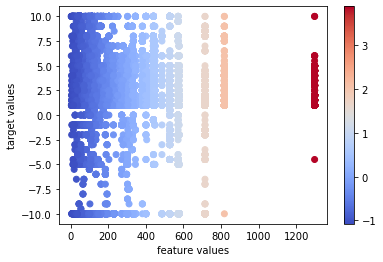

In [79]:
z_scores_rand = ((X_tr_rand['Node1_degree']) - (X_tr_rand['Node1_degree']).mean()) / (X_tr_rand['Node1_degree'].std())

# Plot z-scores
plt.scatter((X_tr_rand['Node1_degree']), y_tr_rand, c=z_scores_rand, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('feature values')
plt.ylabel('target values')
plt.show()

and we clean the outliers:

In [80]:
X_tr_rand_z_Node1, y_tr_rand_z_Node1 = X_tr_rand[z_scores_rand <= 3.0], y_tr_rand[z_scores_rand <= 3.0]

print("Size of the data before cleaning outliers: ", X_tr_rand.shape[0], 
      " ; Size of the data after cleaning outliers: ", X_tr_rand_z_Node1.shape[0])

Size of the data before cleaning outliers:  23445  ; Size of the data after cleaning outliers:  22822


The same is done for the outliers in **Node2_degree** feature:

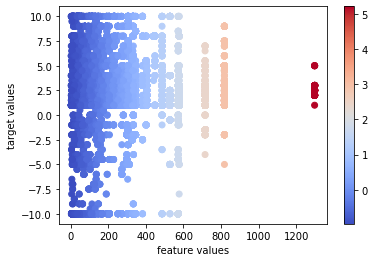

In [81]:
z_scores_rand = ((X_tr_rand_z_Node1['Node2_degree']) - (X_tr_rand_z_Node1['Node2_degree']).mean()) / (X_tr_rand_z_Node1['Node2_degree'].std())

# Plot z-scores
plt.scatter((X_tr_rand_z_Node1['Node2_degree']), y_tr_rand_z_Node1, c=z_scores_rand, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('feature values')
plt.ylabel('target values')
plt.show()

In [82]:
X_tr_rand_z_Node1_Node2, y_tr_rand_z_Node1_Node2 = X_tr_rand_z_Node1[z_scores_rand <= 3.0], y_tr_rand_z_Node1[z_scores_rand <= 3.0]

print("Size of the data before cleaning outliers: ", X_tr_rand_z_Node1.shape[0], 
      " ; Size of the data after cleaning outliers: ", X_tr_rand_z_Node1_Node2.shape[0])

Size of the data before cleaning outliers:  22822  ; Size of the data after cleaning outliers:  22718


Now, we create a Linear Regression model to see if it is capable of estimating the correct weight of the edge:

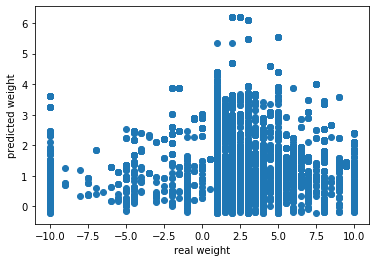

In [83]:
Linear_reg = LinearRegression().fit(X_tr_rand_z_Node1_Node2, y_tr_rand_z_Node1_Node2)

y_pred_rand = Linear_reg.predict(X_test_rand)

residual = y_test_rand - y_pred_rand

plt.scatter(y_test_rand, y_pred_rand)
plt.xlabel('real weight')
plt.ylabel('predicted weight')

plt.show()

In [84]:
print("Linear Regression Model Test Coefficient of Determination: ", round(Linear_reg.score(X_tr_rand_z_Node1_Node2, y_tr_rand_z_Node1_Node2), 4))

Linear Regression Model Test Coefficient of Determination:  0.0427


Unfortunately, it seems that the model was not successful in estimating the correct weight by a very low score of **0.0427**.

To increase the precision of the model, we add three additional features: **Degree of the 3rd node in a triad**, and **the weights of the other two edges in a triad**:

In [85]:
X_tr_rand_2 = Bitcoinotc_df_tr_rand[['Node1_degree', 'Node2_degree', 'Node3_degree', 'w_02', 'w_12']]
X_test_rand_2 = Bitcoinotc_df_test_rand[['Node1_degree', 'Node2_degree', 'Node3_degree', 'w_02', 'w_12']]

y_tr_rand_2 = Bitcoinotc_df_tr_rand[['w_01']]
y_test_rand_2 = Bitcoinotc_df_test_rand[['w_01']]

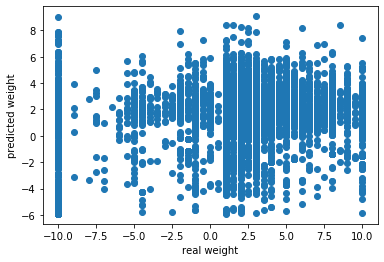

In [86]:
Linear_reg_2 = LinearRegression().fit(X_tr_rand_2, y_tr_rand_2)

y_pred_rand_2 = Linear_reg_2.predict(X_test_rand_2)

residual_2 = y_test_rand_2 - y_pred_rand_2

plt.scatter(y_test_rand_2, y_pred_rand_2)
plt.xlabel('real weight')
plt.ylabel('predicted weight')

plt.show()

In [87]:
print("Linear Regression Model Test Coefficient of Determination: ", round(Linear_reg_2.score(X_tr_rand_2, y_tr_rand_2), 4))

Linear Regression Model Test Coefficient of Determination:  0.2791


The model is not yet performing robustly. However, the score has increased significantly and reached to **0.2791**.

Now, let's try a more sophisticated regression-based model: the **Gradient Boosting Regressor**

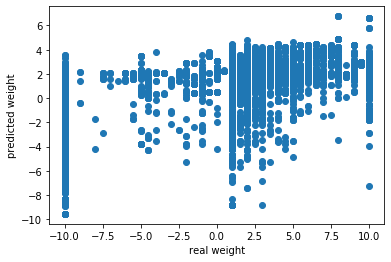

In [88]:
gbreg = GradientBoostingRegressor().fit(X_tr_rand_z_Node1_Node2, y_tr_rand_z_Node1_Node2.values.ravel())

y_pred_rand_gbreg = gbreg.predict(X_test_rand)

residual = y_test_rand.values.ravel() - y_pred_rand_gbreg

plt.scatter(y_test_rand, y_pred_rand_gbreg)
plt.xlabel('real weight')
plt.ylabel('predicted weight')

plt.show()

In [89]:
print("Gradient Boosting Model Test Coefficient of Determination: ", 
      round(gbreg.score(X_test_rand, y_test_rand.values.ravel()), 4))

Gradient Boosting Model Test Coefficient of Determination:  0.4117


The score of gradient boosting is incredibly higher than the linear regression model with just two features **(0.4117)**

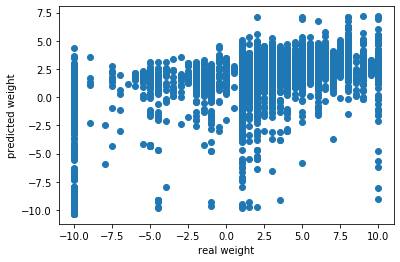

In [90]:
gbreg_2 = GradientBoostingRegressor().fit(X_tr_rand_2, y_tr_rand_2.values.ravel())

y_pred_rand_gbreg_2 = gbreg_2.predict(X_test_rand_2)

residual = y_test_rand_2.values.ravel() - y_pred_rand_gbreg_2

plt.scatter(y_test_rand_2, y_pred_rand_gbreg_2)
plt.xlabel('real weight')
plt.ylabel('predicted weight')

plt.show()

In [91]:
print("Gradient Boosting Model Test Coefficient of Determination: ", 
      round(gbreg_2.score(X_test_rand_2, y_test_rand_2.values.ravel()), 4))

Gradient Boosting Model Test Coefficient of Determination:  0.5724


With 5 features, the gradient boosting regressor is not still the best, by a score of **0.5724** is not that bad.

## 7. Conclusion
Two approaches were used in this project to estimate the outcome of a trade in a crypto-currency trading platform. The first approach was based on the **balance theory** in which the edge signs of generated triads were shuffled and the distribution of actual triad types were compared to the distribution of the triad types gnerated through the shuffling method. The outcome of this prediction can be used by a suggestion engine to suggest a trader to another trader. The goal of this suggestion engine is to gurantee successful trades for the users of the trading platform. As a result, the higher the confidence in the result, the better. If the undesirable triad types are under-presented in the actual data compared to the shuffle data, it means that by shuffling the edge signs we are more likely to get an undesirable estimation than it may happen in reality. This means that the engine works on the safe side!

Finally, two regression-based models were used to estimate the rating outcome of a future trade. The linear regression-based model was not so successful in estimating the weights, scoring very low. However, the gradient boosting regressor was able to give better results even by using low number of features (just the total ratings of the two sides of a trade).